# Loose EEGNet
This notebook is a neural network that is based as much off of the EEGNet paper as I could understand.



---



# Import/Install all necessary packages and libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, gradcheck
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd

from matplotlib import pyplot

import math

from os import walk

# Check for GPU availability and set device

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load and format the data

Here is a brief rundown of the data:

> Each data segment (chunk) is a two second recording in which a subject subvocalized either "yes" or "no" at any point in the recording

> The data is taken with a sampling frequency of 250hz, so in the end there are 500 timepoints for each chunk

> The hardware we are using has 7 channels

> After all these data cells are run the data is in the shape (# of chunks, 1, # of channels, # of timepoints)









In [5]:
master_data, master_label = [], []
datafix, labelfix = ".pkl", ".csv"
# paste path below
for (dirpath, dirnames, filenames) in walk('/content/drive/Shareddrives/NeuroTech ML/Processed Data Files'):
    new_data = [dirpath + '/' + name for name in filenames if datafix in name]
    master_data.extend(new_data)

    new_labels = [dirpath + '/' + name for name in filenames if labelfix in name]
    master_label.extend(new_labels)
assert len(master_data) == len(master_label)
master_data.sort()
master_label.sort()
for index in range(len(master_data)):
    try: 
        assert master_data[index][:-4] == master_label[index][:-11]
    except:
        print(index)
        print(master_data[index][:-4])
        print(master_label[index][:-11])

In [6]:
pkllabels = np.zeros((1, 1))
pkldata = np.zeros((1, 7, 500))
pkllabels2 = np.zeros((1, 1))
pkldata2 = np.zeros((1, 7, 500))

for i in range(len(master_data)):

    # To train no ICA data change data type to ICA
    # To train no ICA and weaker filter change data type to Weaker
    # To train unprocessed data change data type to Unprocessed

    data_type = "Char_Jar"

    if data_type in master_data[i]:
        new_data = pd.read_pickle(master_data[i])

        new_labels = pd.read_csv(master_label[i], delimiter=',', header=None)
        if new_labels.shape[0] == 1 and new_labels.shape[1] > new_labels.shape[0]:
            new_labels = new_labels.T
        new_labels = np.array(new_labels)
        new_labels = new_labels.reshape((new_labels.shape[0], 1))

        pkldata = np.concatenate((pkldata, new_data), axis = 0)
        pkllabels = np.concatenate((pkllabels, new_labels), axis = 0)
    # elif data_type in master_data[i] and 'YESNO' in master_data[i]:
    #     new_data = pd.read_pickle(master_data[i])

    #     new_labels = pd.read_csv(master_label[i], delimiter=',', header=None)
    #     if new_labels.shape[0] == 1 and new_labels.shape[1] > new_labels.shape[0]:
    #         new_labels = new_labels.T
    #     new_labels = np.array(new_labels)
    #     new_labels = new_labels.reshape((new_labels.shape[0], 1))

    #     pkldata2 = np.concatenate((pkldata2, new_data), axis = 0)
    #     pkllabels2 = np.concatenate((pkllabels2, new_labels), axis = 0)

pkllabels = pkllabels[1:, :]
pkldata = pkldata[1:, :, :]
pkllabels2 = pkllabels2[1:, :]
pkldata2 = pkldata2[1:, :, :]

(183, 7, 500) (183, 1)
(183, 1)
(91, 7, 500) (92, 7, 500)


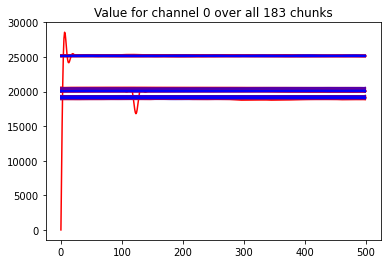

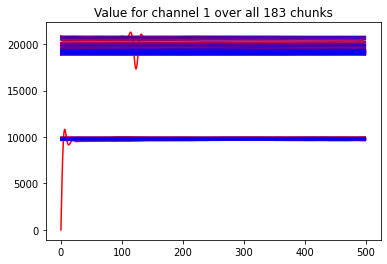

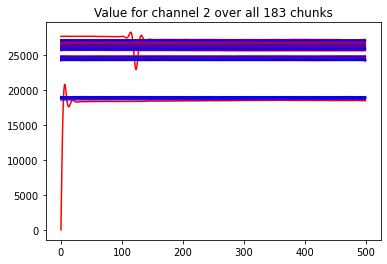

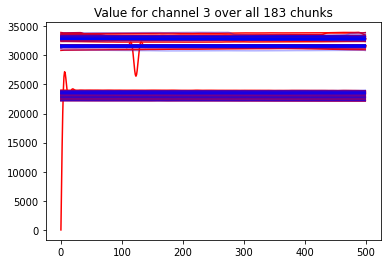

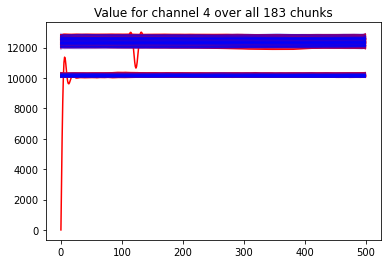

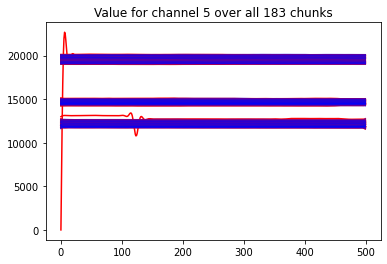

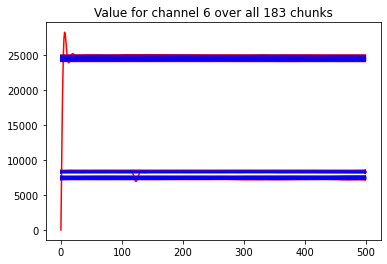

In [10]:
# Uncomment below if u wanna see a bunch of graphs of the data
print(pkldata.shape, pkllabels.shape)
print(pkllabels.shape)
x = pkldata[0]
only_no = [pkldata[i] for i in range(pkldata.shape[0]) if pkllabels[i][0] == 0]
only_no = np.array(only_no)
only_yes = [pkldata[i] for i in range(pkldata.shape[0]) if pkllabels[i][0] == 1]
only_yes = np.array(only_yes)
print(only_no.shape, only_yes.shape)
for i in range(pkldata.shape[1]):
    g = i + 1
    pyplot.plot(only_yes[0:, i, :].T, color="red")
    pyplot.plot(only_no[0:, i, :].T, alpha = .3, color="blue")
    pyplot.title("Value for channel {} over all {} chunks".format(i, pkldata.shape[0]))
    #pyplot.savefig(f"/content/drive/My Drive/Extra/processed_data_Riley_channel_{g}.png")
    pyplot.show()

In [7]:
torch.manual_seed(4)
torch.cuda.manual_seed(4)

In [8]:
channels = pkldata.shape[1]
timepoints = pkldata.shape[2]
print(channels, timepoints)

7 500


In [9]:
BATCH_SIZE = 32

pkllabels = pkllabels.astype(np.float32)
X_actual = torch.from_numpy(pkllabels)

scaler = StandardScaler()
X_train = pkldata
# for i in range(len(X_train)):
#     X_train[i] = scaler.fit_transform(X_train[i])
X_train = torch.from_numpy(X_train)
X_train = X_train.unsqueeze(1)

# pkllabels2 = pkllabels2.astype(np.float32)
# X_test_labels = torch.from_numpy(pkllabels2)

# X_test = pkldata2
# X_test = torch.from_numpy(X_test)
# X_test = X_test.unsqueeze(1)

# splits the data into a train and dev set, and loads them into dataloaders
train_data, test_data, labels_train, labels_test = train_test_split(X_train, X_actual, test_size=0.2, random_state=4)

# test_data = X_test
# labels_test = X_test_labels

trainset = torch.utils.data.TensorDataset(train_data, labels_train)
testset = torch.utils.data.TensorDataset(test_data, labels_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = test_data.shape[0], shuffle = True, drop_last=True)

print(train_data.shape, test_data.shape, labels_train.shape, labels_test.shape)

torch.Size([146, 1, 7, 500]) torch.Size([37, 1, 7, 500]) torch.Size([146, 1]) torch.Size([37, 1])


# Build the model and train
A short breakdown of the paper:
> EEGNet is a CNN for classification and interpretation of EEG-based BCI's

> Benefits of EEGNet:
> 1. Can be applied to different BCI paradagims (MI, ERP, SSVEP)
> 2. Can be trained with very limited data
> 3. Can produce neurophysiologically interpretable features

> The model architecture:
> 1. Fit 2D convolutional filters of size (1, sampling rate//2)
> 2. Use a depthwise convolution of size (# of channels, 1)
> 3. Add a separable convolution of size (1, 16)
> 4. Flatten the data and feed it through a classification layer







In [11]:
# hyperparameters
freq, avg1stride, avg2stride = 250, (1, 4), (1, 8)
convstride = 1 # stride for each conv2D
conv1_neurons = 4
conv2_neurons = 8
conv3_neurons = 32
conv4_neurons = 16
kern1size = freq // 2
kern3size = 32

In [12]:
padding_needed = (kern1size - 1) / 2
conv1outx, conv1outy = (channels, (timepoints + (2 * padding_needed) - kern1size)/convstride + 1)

print("1st layer output size:", conv1outx, conv1outy)

conv2outx, conv2outy = ((conv1outx - channels)/convstride + 1, conv1outy)
conv2outx, conv2outy = conv2outx // avg1stride[0], conv2outy // avg1stride[1]

print("2nd layer output size:", conv2outx, conv2outy)

# conv3outx, conv3outy = (conv2outx, (conv2outy - kern3size)/convstride + 1)

# print("3rd layer output size:", conv3outx, conv3outy)

# conv4outx, conv4outy = (conv3outx, conv3outy)
# conv4outx, conv4outy = (conv4outx // avg2stride[0], conv4outy // avg2stride[1])

# print("4th layer output size:", conv4outx, conv4outy)

# flat1_in = int(conv4outx * conv4outy * conv4_neurons)

flat1_in = int(conv2outx * conv2outy * conv2_neurons)

1st layer output size: 7 500.0
2nd layer output size: 1.0 125.0


Model description, layer by layer

1. Temporal convolution
> * - Uses filters of (1, sampling frequency // 2)
> * - Learns frequency filters at 2Hz and above
2. Depthwise convolution
> * - Learns spatial filters
3. Separable Convolution
> * - Conists of a deptwise convolution followed by a pointwise convolution
> * - First learnes a kernel summarizing each feature map, then merges the outputs
4. Fully connected layer
> * - Consists of a linear layer that reduces the channels, followed by a sigmoid classification

3.5k research grant at school

https://science.ucsc.edu/research-opportunities/undergraduate-research-in-science-and-technology-award/




In [13]:
class ConstrainedConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [14]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.pad = nn.ZeroPad2d((math.floor(padding_needed), math.ceil(padding_needed), 0, 0))
        self.conv1 = nn.Conv2d(1, conv1_neurons, (1, kern1size), bias=False)
        self.norm1 = nn.BatchNorm2d(conv1_neurons)
        self.conv2 = ConstrainedConv2d(conv1_neurons, conv2_neurons, (channels, 1), bias=False)
        self.norm2 = nn.BatchNorm2d(conv2_neurons)
        self.pool = nn.MaxPool2d(avg1stride)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flat1_in, 1)
        self.dropout = nn.Dropout()

        self.activation = nn.ELU()
        self.activation2 = nn.Sigmoid()

    def forward(self, x):
        out = self.pad(x)
        out = self.conv1(out)
        out = self.activation(out)
        out = self.norm1(out)

        out = self.conv2(out)
        out = self.activation(out)
        out = self.pool(self.norm2(out))
        out = self.dropout(out)

        out = self.activation2(self.fc1(self.flatten(out)))
        return out

CNNPoor = EEGNet()

In [15]:
# CNNPoor = nn.Sequential(
#     nn.ZeroPad2d((math.floor(padding_needed), math.ceil(padding_needed), 0, 0)),
#     nn.Conv2d(1, conv1_neurons, (1, kern1size), bias=False),
#     nn.ELU(),
#     nn.BatchNorm2d(conv1_neurons),
    
#     ConstrainedConv2d(conv1_neurons, conv2_neurons, (channels, 1), bias=False),
#     nn.ELU(),
#     nn.BatchNorm2d(conv2_neurons),
#     nn.MaxPool2d(avg1stride),
#     nn.Dropout(),
    
#     # nn.Conv2d(conv2_neurons, conv3_neurons, (1, kern3size), bias=False, groups=conv2_neurons),
#     # nn.Conv2d(conv3_neurons, conv4_neurons, kernel_size=1, bias=False),
#     # nn.ELU(),
#     # nn.BatchNorm2d(conv4_neurons),
#     # nn.MaxPool2d(avg2stride),
#     # nn.Dropout(),
    
#     nn.Flatten(),

#     nn.Linear(flat1_in, 1),
#     nn.Sigmoid(),
# )

CNNPoor = CNNPoor.to(device)

In [16]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(CNNPoor.parameters(), lr = 0.001)

In [17]:
def test(model, device, test_loader):
    
    model.eval()
    correct = 0
    tot_loss = 0
    acc_score, prec_score, rec_score = 0, 0, 0
    with torch.no_grad():
        for (data, labels) in test_loader:
            data, labels = data.to(device), labels.to(device)
            
            classification = model(data.float())
            loss = loss_function(classification, labels)

            pred = torch.round(classification)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            tot_loss += loss.item()

            acc_score += accuracy_score(labels, pred)
            prec_score += precision_score(labels, pred)
            rec_score += recall_score(labels, pred)

        print("\nTest set: Total loss: {:.6f}, Accuracy: {:.6f}".format(tot_loss, 
                                                                          correct / len(test_loader.dataset)))
        # print(classification_report(labels, pred))
        return (tot_loss, acc_score, prec_score, rec_score)

In [18]:
def train(model, device, train_loader, optimizer, epoch):

    model.train()
    correct = 0
    tot_loss = 0
    for batch, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        classification = model(data.float())
        loss = loss_function(classification, labels)

        loss.backward()
        optimizer.step()

        pred = torch.round(classification)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        tot_loss += loss.item()
    print("Epoch: {}".format(epoch))
    print("\tAverage loss: {:.6f}".format(tot_loss / (batch + 1)))
    print("\tAccuracy: {:.6f}".format(correct / len(train_loader.dataset)))

    labels_detached = labels.detach()
    preds_detached = pred.detach()
    print(classification_report(labels_detached, preds_detached))
    return (tot_loss / (batch + 1), correct / len(train_loader.dataset))

In [19]:
plots = {"train loss": [],
         "train acc": [],
         "test loss": [],
         "test acc": [],
         "test prec": [],
         "test rec": []}

for epoch in range(120):
    trl, tra = train(CNNPoor, device, train_loader, optimizer, epoch)
    plots["train loss"].append(trl)
    plots["train acc"].append(tra)
    tl, ta, tp, tr = test(CNNPoor, device, test_loader)
    plots["test loss"].append(tl)
    plots["test acc"].append(ta)
    plots["test prec"].append(tp)
    plots["test rec"].append(tr)

Epoch: 0
	Average loss: 0.808697
	Accuracy: 0.424658
              precision    recall  f1-score   support

         0.0       0.55      0.71      0.62        17
         1.0       0.50      0.33      0.40        15

    accuracy                           0.53        32
   macro avg       0.52      0.52      0.51        32
weighted avg       0.52      0.53      0.51        32


Test set: Total loss: 0.777800, Accuracy: 0.378378


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1
	Average loss: 0.766438
	Accuracy: 0.431507
              precision    recall  f1-score   support

         0.0       0.56      0.26      0.36        19
         1.0       0.39      0.69      0.50        13

    accuracy                           0.44        32
   macro avg       0.47      0.48      0.43        32
weighted avg       0.49      0.44      0.42        32


Test set: Total loss: 0.734523, Accuracy: 0.378378
Epoch: 2
	Average loss: 0.797961
	Accuracy: 0.424658
              precision    recall  f1-score   support

         0.0       0.57      0.75      0.65        16
         1.0       0.64      0.44      0.52        16

    accuracy                           0.59        32
   macro avg       0.60      0.59      0.58        32
weighted avg       0.60      0.59      0.58        32


Test set: Total loss: 0.791846, Accuracy: 0.378378
Epoch: 3
	Average loss: 0.777355
	Accuracy: 0.465753
              precision    recall  f1-score   support

         0.0       0.67     

torch.Size([4, 1, 1, 125])


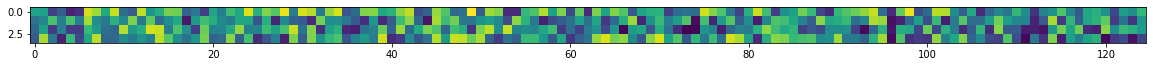

In [20]:
conv1 = list(CNNPoor.children())
print(conv1[1].weight.shape)
weight1 = conv1[1].weight.reshape((4,125)).data.numpy()
#weight2 = conv1[4].weight.reshape((16,7)).data.numpy()
# weight3 = conv1[9].weight.reshape((32,32)).data.numpy()
#weight4 = conv1[10].weight.reshape((16,32)).data.numpy()
# weight5 = conv1[16].weight.reshape((1,176)).data.numpy()
pyplot.figure(figsize=(20,10))
pyplot.imshow(weight1)

#pyplot.imshow(weight2)
#pyplot.imshow(weight3)
#pyplot.imshow(weight4)
# pyplot.imshow(weight5)

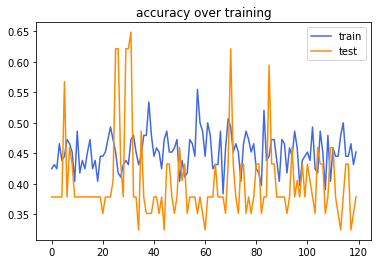

In [21]:
pyplot.plot(plots["train acc"], "royalblue", label = "train")
pyplot.plot(plots["test acc"], "darkorange", label = "test")
pyplot.title("accuracy over training")
pyplot.legend()
pyplot.show()

In [22]:
# tload = torch.utils.data.TensorDataset(X_train, X_actual)
# tloader = torch.utils.data.DataLoader(tload, batch_size = X_train.shape[0], shuffle = True)
# _, _, _, _ = test(CNNPoor, device, tloader)
_, _, _, _ = test(CNNPoor, device, test_loader)


Test set: Total loss: 0.763911, Accuracy: 0.378378


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# torch.save(CNNPoor.state_dict(), '/content/drive/Shared drives/NeuroTech ML/my_model.pt')

In [24]:
# import pickle

# pickle.dump(CNNPoor, open('model.pkl', 'wb'))
# # model = pickle.load(open('model.pkl', 'rb'))
